In [1]:
import tensorflow as tf
import numpy as np
import os

# Diretórios
train_dir = "../train"
test_dir = "../test"

In [2]:
# Parâmetros
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Carregar datasets
train_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

test_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
class_names = train_ds_original.class_names
print("Classes encontradas:", class_names)

Found 6802 files belonging to 5 classes.
Found 2562 files belonging to 5 classes.
Classes encontradas: ['A', 'E', 'I', 'O', 'U']


In [3]:
# Converter para Grayscale
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

train_ds = train_ds_original.map(convert_to_grayscale).map(lambda x, y: (x / 255.0, y))
test_ds = test_ds_original.map(convert_to_grayscale).map(lambda x, y: (x / 255.0, y))


In [4]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])

In [5]:
# Pré-processamento: transformar grayscale (1 canal) para 3 canais (necessário para o modelo pré-treinado)
def expand_channels(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds = train_ds.map(expand_channels)
test_ds = test_ds.map(expand_channels)

In [6]:
# Aplicar Data Augmentation somente no treino
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Melhor desempenho (pipeline otimizado)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Transfer Learning com MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congelar pesos

In [7]:
# Montar o modelo final
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [9]:
# Compilação
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping (evita overfitting)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7651 - loss: 0.6626 - val_accuracy: 0.7904 - val_loss: 0.7201
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8330 - loss: 0.4661 - val_accuracy: 0.7701 - val_loss: 0.6722
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8706 - loss: 0.3565 - val_accuracy: 0.7299 - val_loss: 0.6861
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8920 - loss: 0.3099 - val_accuracy: 0.7545 - val_loss: 0.6732
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9070 - loss: 0.2619 - val_accuracy: 0.7611 - val_loss: 0.6026


In [18]:
# Avaliação final
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Acurácia final no teste: {test_accuracy:.2%}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 48s 581ms/step - accuracy: 0.7909 - loss: 0.5641
Acurácia final no teste: 76.11%


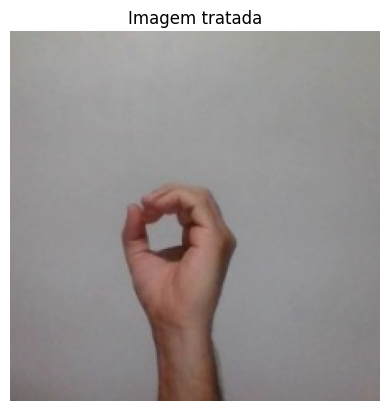

In [21]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

#caminho das imagens
caminho = '../test/o/101.jpg'

#abrir imagem com PIL
img = Image.open(caminho)# L = grayscale

#redimensiona opara 28x28 pixls (formato do dataset Fashion MNIST)
img = img.resize((224,224))

#converter para array numpy e normalizar
img_array = np.array(img) / 255.0  #nomalizar par 0-1(preto ou branco)

#oprcional -  inverte cores se o fundo para escuro se a peça for clara
# img_array = 1 - img_array

#adiciona a dimensao de lote (batch_size=1)
img_array = img_array.reshape(1,224,224,3) #em 1 dimensao no formato 28x28

import matplotlib.pyplot as plt
plt.imshow(img_array[0], cmap='gray')
plt.title('Imagem tratada')
plt.axis('off')
plt.show()

In [22]:
#previsao da classe
predicao = model.predict(img_array)

#idetificando o indice da classe cm maior probabilidade
indice_classe = np.argmax(predicao)

print(f'Classe prevista: {class_names[indice_classe]}')
print(f'Confirança: {predicao[0][indice_classe]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classe prevista: O
Confirança: 68.49%


In [23]:
model.save("modelo2_libras.h5")